#### Pairs Trading and Coinitegration Strategy

Importing necessary libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

Fetching data from yfinance API

In [30]:
companies=pd.DataFrame()
stocks=["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "JPM", "WMT", "JNJ", "V", "PG", "KO", "NFLX", "DIS", "NVDA", "VZ", "T", "IBM", "HD","BA","MA"]
for stock in stocks:
    stk=yf.Ticker(stock)
    data=stk.history(start='2017-06-01',end='2023-07-31')
    companies[stock]=data['Close']
companies.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA,JPM,WMT,JNJ,V,PG,KO,NFLX,DIS,NVDA,VZ,T,IBM,HD,BA,MA
Date,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00-04:00,35.988792,64.893456,49.414501,49.797501,22.691334,68.987946,71.182976,109.020241,91.476555,74.337860,37.248367,162.990005,103.624084,35.656986,33.635223,17.609217,108.414429,133.570282,176.507385,118.973724
2017-06-02 00:00:00-04:00,36.522114,66.430145,49.806000,50.336498,22.656668,68.639107,71.013512,110.120758,92.195732,74.725861,37.329716,165.179993,102.637741,35.479134,33.584610,17.609217,107.974144,133.742508,179.249374,120.709175
2017-06-05 00:00:00-04:00,36.164997,66.911530,50.194000,50.567001,23.154667,68.763695,71.584320,110.357811,92.579277,74.852379,37.411053,165.059998,102.005707,36.558525,33.533985,17.582037,108.229790,133.260361,178.043259,121.384048
2017-06-06 00:00:00-04:00,36.287163,67.133705,49.834000,50.150002,23.523333,68.904877,70.398079,110.755676,91.850517,74.903000,37.402927,165.169998,101.028938,36.393040,33.584610,17.545792,108.201378,132.752426,175.970261,120.747719
2017-06-07 00:00:00-04:00,36.503326,67.013351,50.075001,50.503502,23.976667,69.693939,70.594307,110.687965,92.138199,74.877670,37.020599,165.610001,101.431129,36.832699,33.627987,17.559383,107.214279,133.406723,177.242355,120.699532


Dividing the full dataframe into two parts 
1. Lookback period for selection of pair of companies
2. BackTesting period for testing out strategy

In [31]:
train_close, test_close = train_test_split(companies, test_size=0.5, shuffle=False)

Plotting the HeatMap containing the correlation value of every pair of companies

Text(0.5, 1.0, 'Assets Correlation Matrix')

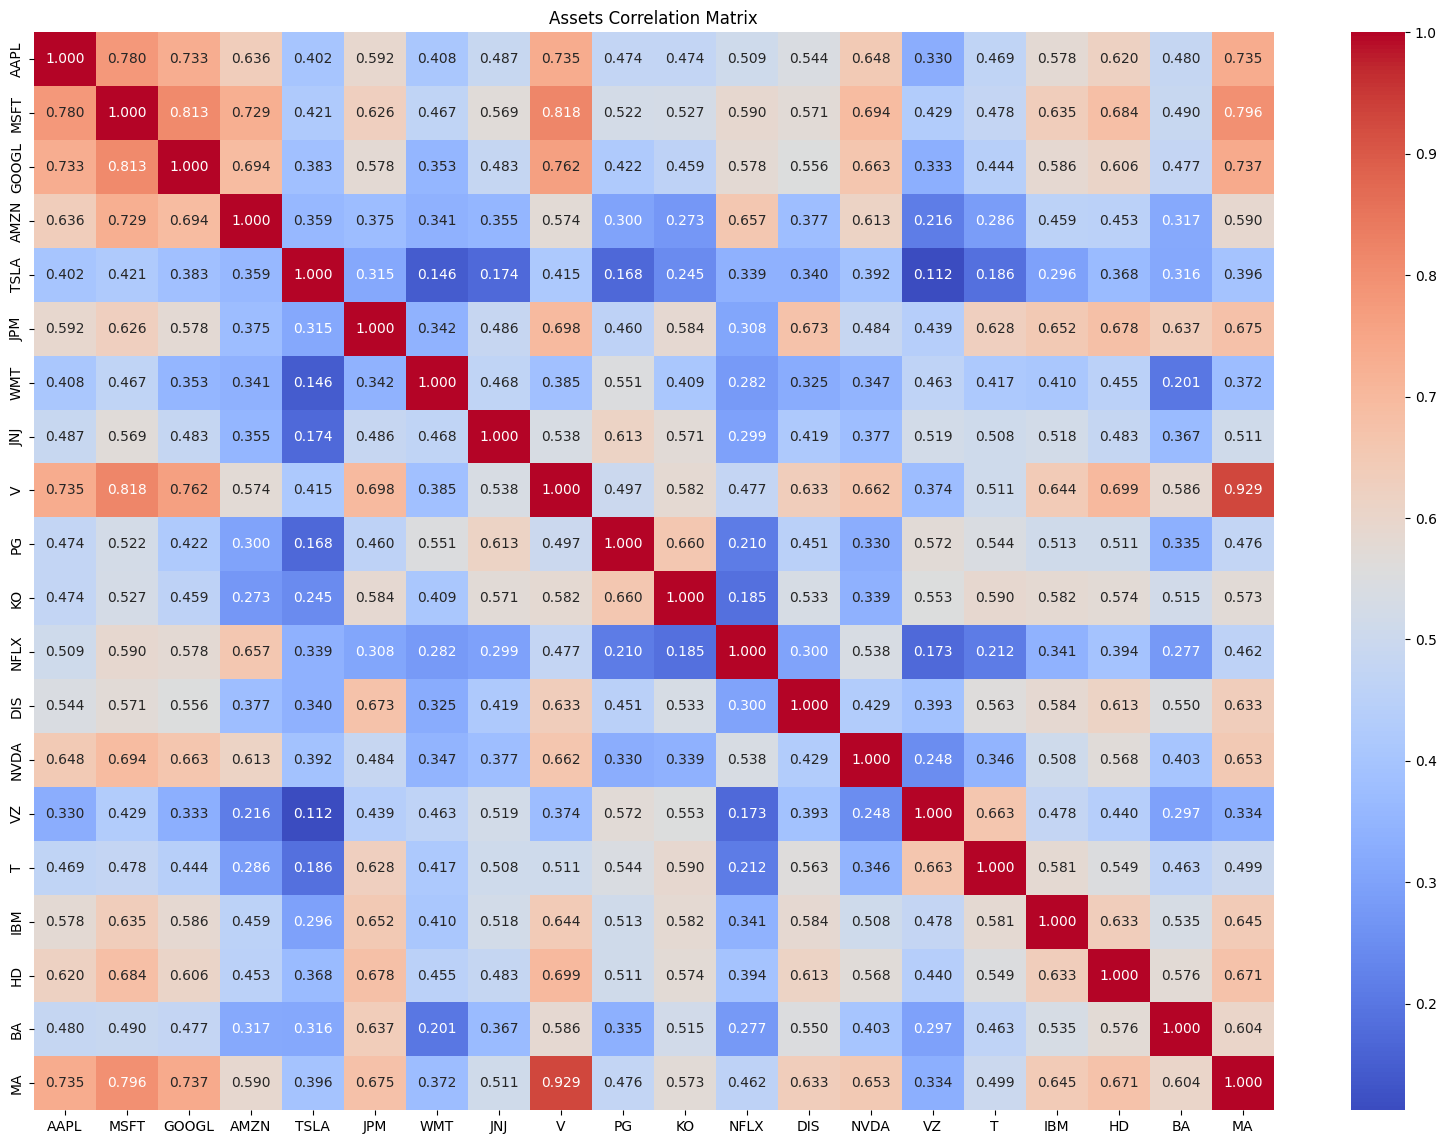

In [32]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".3f") #spearman
ax.set_title('Assets Correlation Matrix')

Making a funtion that would return the P value matrix as well as eliminates more companies on the basis of their p values

In [33]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)

[('GOOGL', 'HD'), ('JNJ', 'V'), ('JNJ', 'PG'), ('JNJ', 'VZ'), ('JNJ', 'MA'), ('V', 'MA'), ('KO', 'DIS'), ('IBM', 'HD'), ('IBM', 'BA'), ('IBM', 'MA'), ('HD', 'MA')]


Plotting HeatMap of the P value Matrix

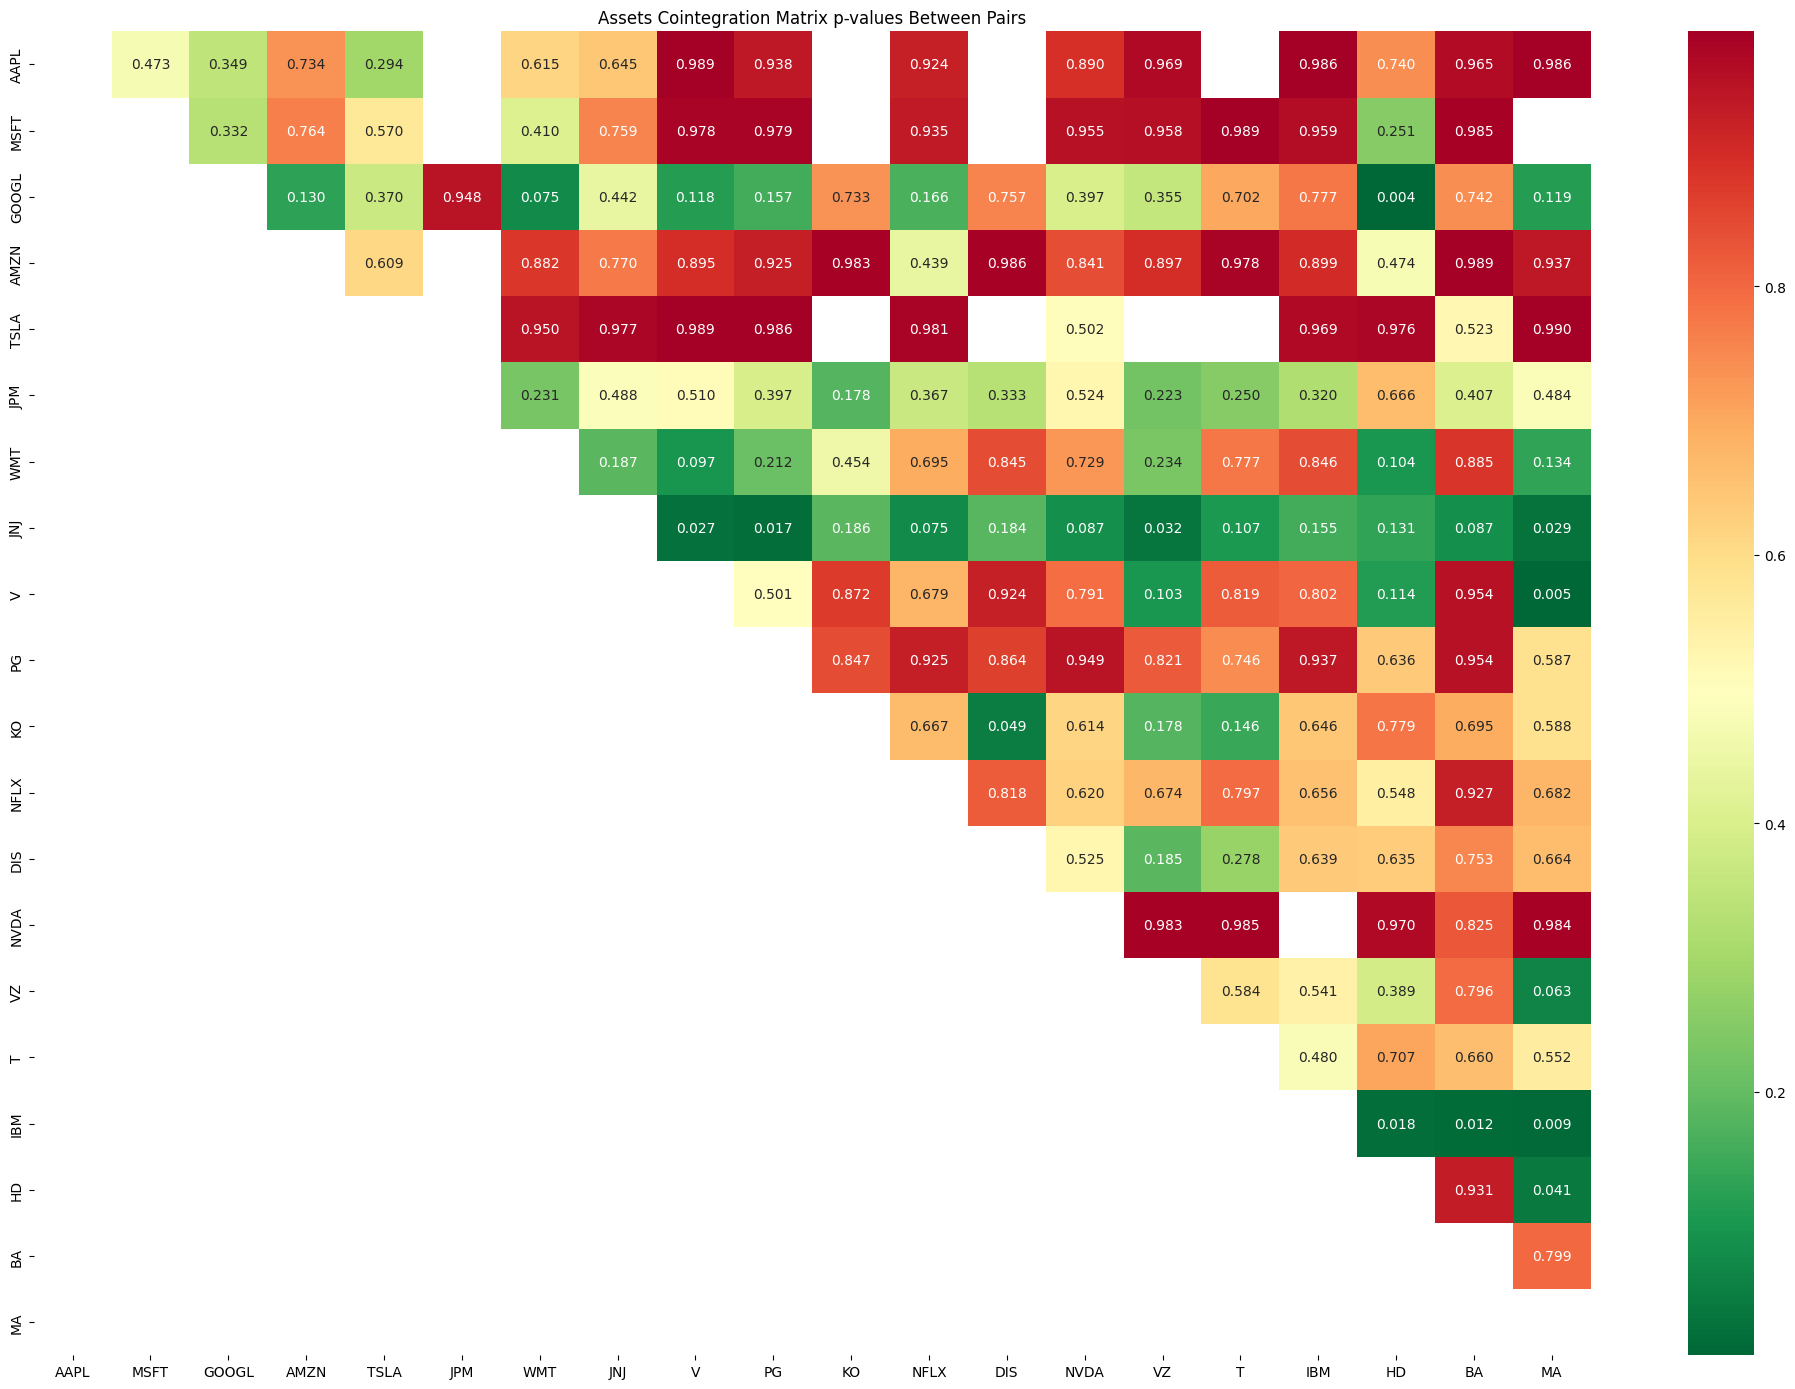

In [34]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".3f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()

##### We are done with selection and out of the 190 pairs we are now left with 11 pairs. We take one of these pairs and apply ADF test and linear regression

Plotting Stock prices of out pair

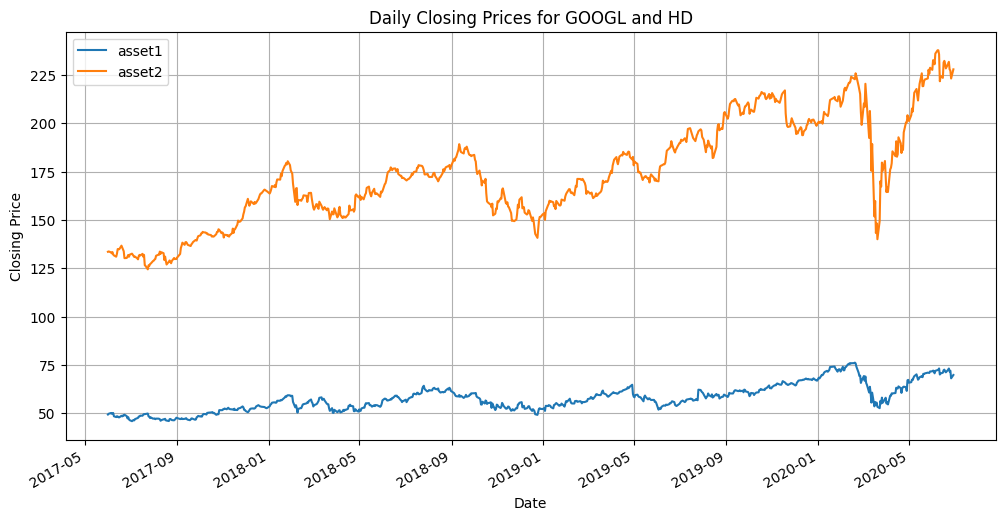

In [35]:
asset1,asset2='GOOGL','HD'
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True); 

Using Linear regression to find $\beta$

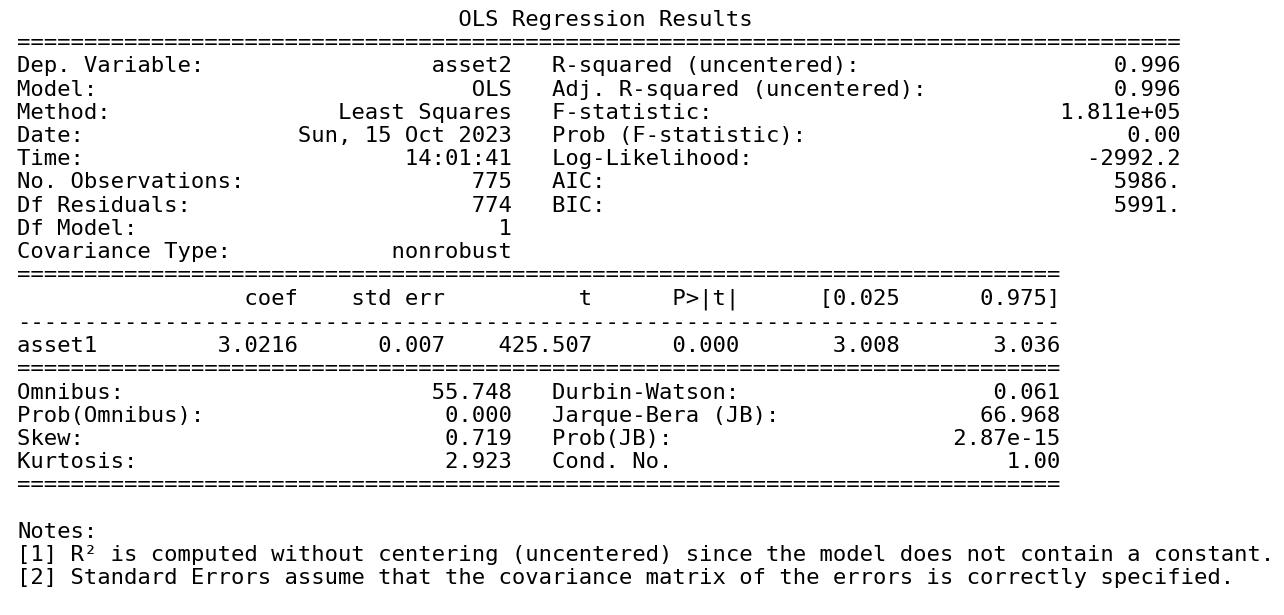

In [36]:
model=sm.OLS(train.asset2, train.asset1).fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

Here model.params[0] $=$ $\beta$
Finding spread and plotting it.

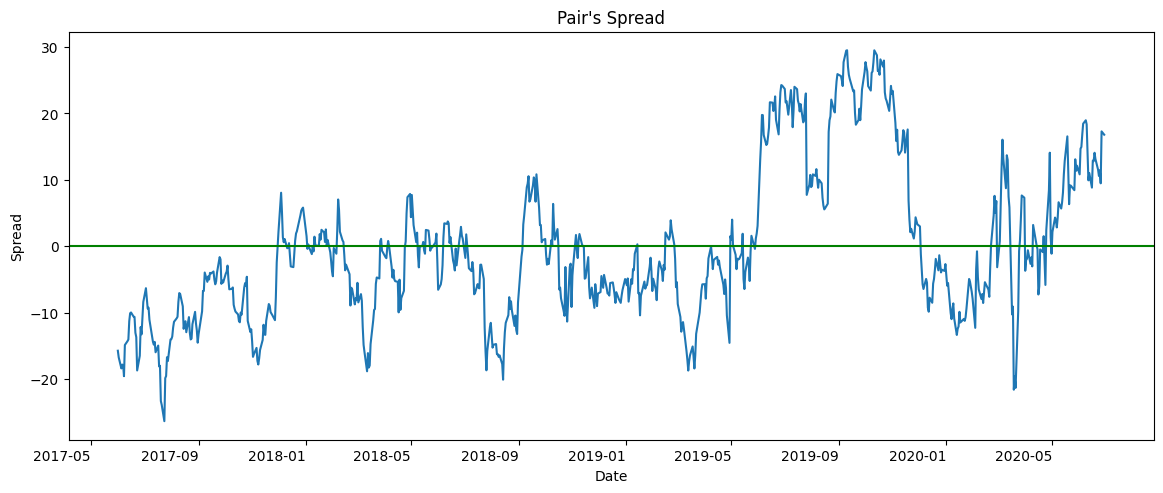

In [37]:
spread = train.asset2 - model.params[0] * train.asset1
ax = spread.plot(figsize=(14, 6), title = "Pair's Spread",rot=0)
ax.set_ylabel("Spread")
ax.axhline(0,c='g')

Applying ADF test

In [38]:
adf = adfuller(spread, maxlag = 1)
print('T- Statistic = ', adf[0])
print("Critical Values",adf[4])

T- Statistic =  -3.4396273995116107
Critical Values {'1%': -3.4388268991356936, '5%': -2.8652813916285518, '10%': -2.5687622857867782}


##### We see that out T-Statistic is less than 1% critical value. Hence we are ready to go

We calculate the Z-SCORE data series for out two assets using moving average over two windows

In [39]:
win=10
test=pd.concat([train_close[train_close.shape[0]-win-1:],test_close], sort=False)
signs = pd.DataFrame()
signs['asset1'] = test[asset1] 
signs['asset2'] = test[asset2]
ratios = signs.asset1 / signs.asset2
ratios_mavg5 = ratios.rolling(window=6, center=False).mean()
ratios_mavg5=ratios_mavg5[win:]
ratios_mavg10 = ratios.rolling(window=win, center=False).mean()
ratios_mavg10=ratios_mavg10[win:]
std_10 = ratios.rolling(window=win, center=False).std()
std_10=std_10[win:]
zscore_10_5 = (ratios_mavg5 - ratios_mavg10)/std_10
ratios=ratios[win:]
zscore_10_5=zscore_10_5.dropna()

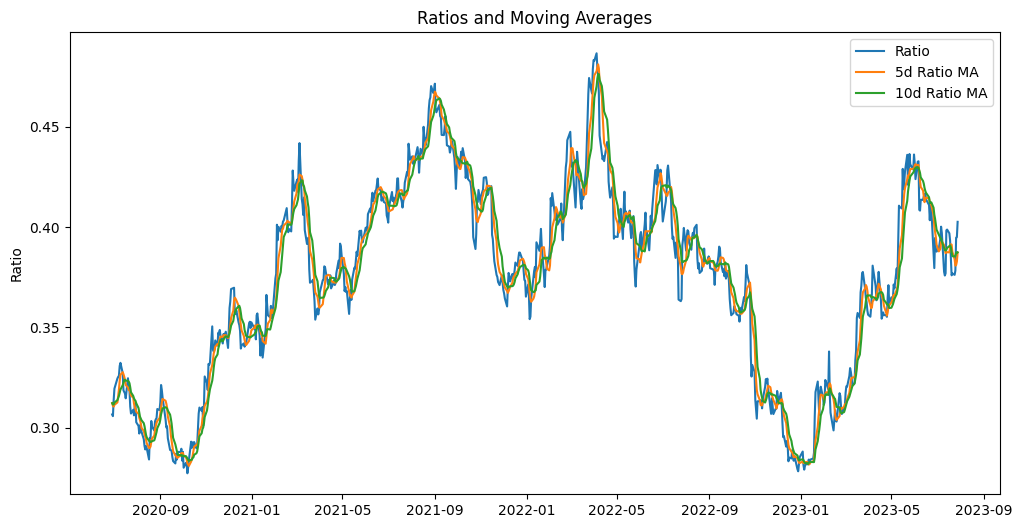

In [40]:
plt.figure(figsize=(12, 6))
plt.title("Ratios and Moving Averages")
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg10.index, ratios_mavg10.values)
plt.legend(['Ratio', '5d Ratio MA', '10d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

Plotting Z Score Data series

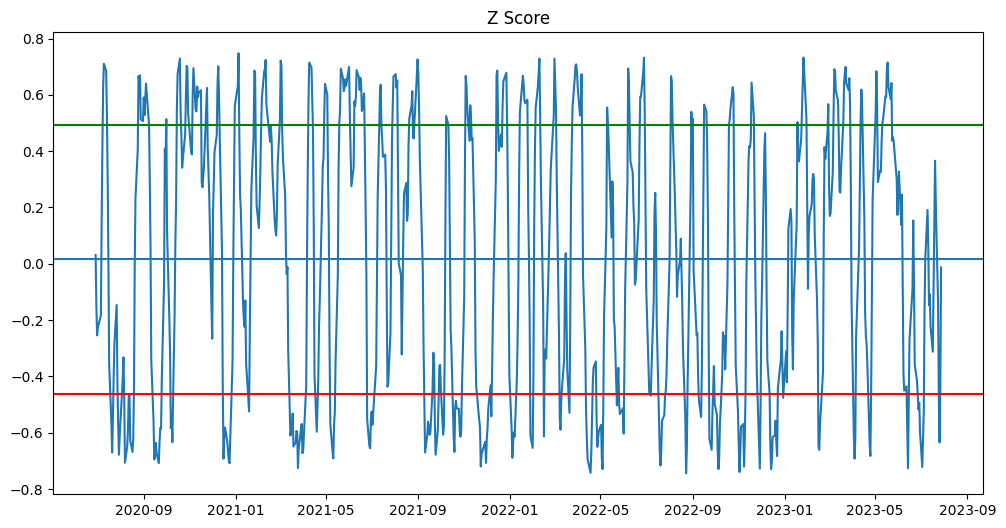

In [41]:
plt.figure(figsize=(12, 6))
plt.title("Z Score")
plt.plot(zscore_10_5)
plt.axhline(zscore_10_5.mean())
plt.axhline(zscore_10_5.std()+zscore_10_5.mean(),c='g')
plt.axhline(zscore_10_5.mean()-zscore_10_5.std(),c='r')

### Signal Generation


In [42]:
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2
signals['z'] = zscore_10_5
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
signals=signals.dropna()

Plotting

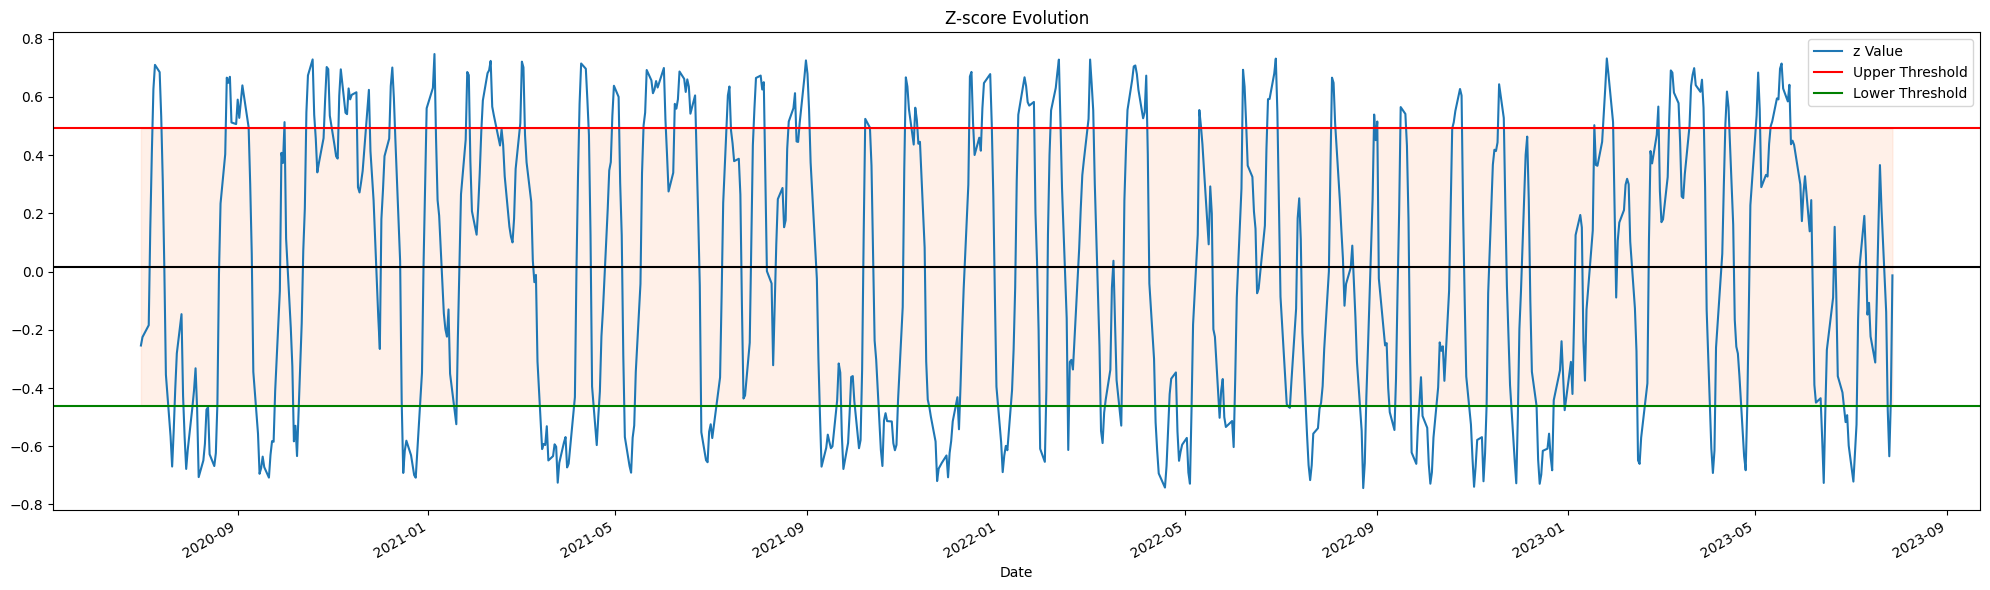

In [43]:
 
plt.figure(figsize=(20,6))
signals['z'].plot(label="z Value")
plt.title("Z-score Evolution")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.fill_between(signals.index,signals['z upper limit'],\
            signals['z lower limit'], \
            alpha=0.2,color='#ffb48f')
plt.legend()
plt.tight_layout()

Plotting Signals over a time frame with markers

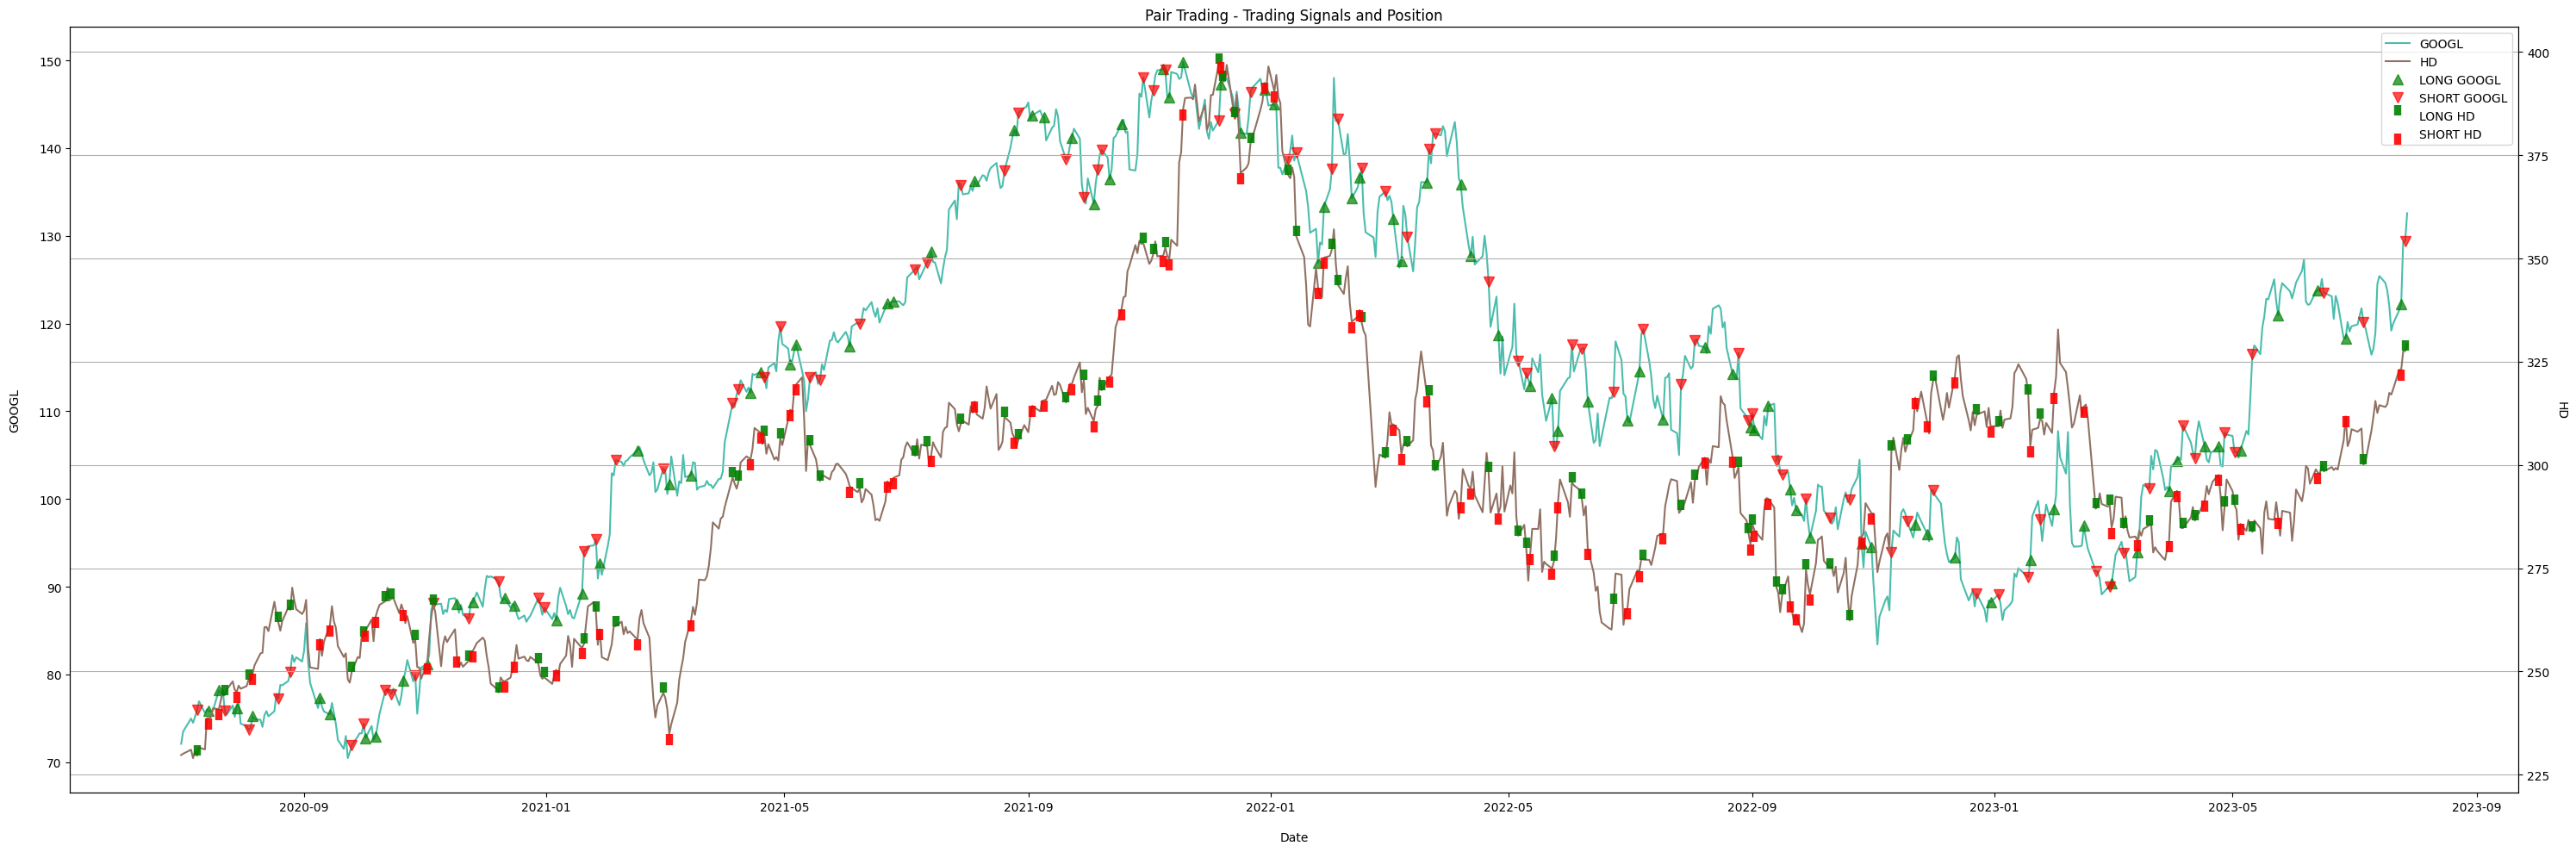

In [49]:
fig=plt.figure(figsize=(30,10))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=6)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=6)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),'SHORT {}'.format(asset1),'LONG {}'.format(asset2),'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

Portofolio

In [45]:
initial_capital = 100000
initial_capital2=initial_capital/(1+model.params[0])
initial_capital1=model.params[0]*initial_capital/(1+model.params[0])
positions1 = initial_capital1// max(signals['asset1'])
positions2 = initial_capital2// max(signals['asset2'])



In [46]:
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital1 - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital2 - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['return']=portfolio['total asset'].pct_change()
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

PLotting our Cumulative Returns

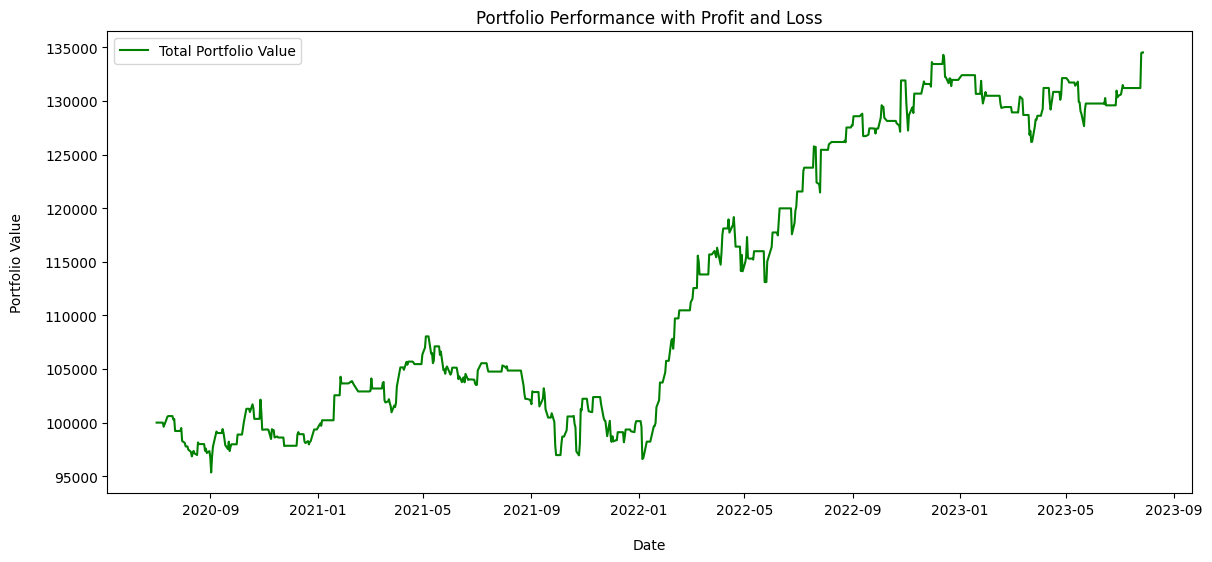

In [47]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
l1, = ax.plot(portfolio['total asset'], c='g')
ax.set_ylabel('Portfolio Value')
ax.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l1],['Total Portfolio Value'],loc='upper left');

Computing CAGR, Maximum Drawdown and Frequency of trades placed

In [48]:
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))
Maximum_Drawdown=(portfolio['total asset'].min()-portfolio['total asset'].max())/portfolio['total asset'].max()
print("Maximum_Drawdown is: ",Maximum_Drawdown)
print("Frequency is: ", signals['asset1'][signals['positions1'] == 1].count())

Number of days =  1121
CAGR = 10.140%
Maximum_Drawdown is:  -0.29122729881711557
Frequency is:  88
